# CNN Image Classifier

## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

2025-04-10 20:03:12.843321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744336992.856985   92421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744336992.860898   92421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744336992.872918   92421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744336992.872945   92421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744336992.872948   92421 computation_placer.cc:177] computation placer alr

## Hyperparameters

In [2]:
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
EPOCHS = 100

## Dataset

The used [Animal Image Dataset](https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals). It was split into a training and testing set at an 80 to 20 ratio using [this script](./split.ipynb)

In [3]:
dataset_dir = os.path.join('datasets', 'animals')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

We build the image loaders. For training we also apply data augmentation through rotation, width shifting, zoom in and horizontal flipping. The images are also rescaled so taht the pixel values are between 0 and 1 instead of 0 to 255

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode="binary",
)

classes = len(train_generator.class_indices)

Found 4320 images belonging to 90 classes.


## Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
)

model = Sequential()
model.add(
    Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    )
)
model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=3, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(classes, activation="softmax"))

model.summary()

I0000 00:00:1744336995.310574   92421 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        23,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,422,138 (32.13 MB)

 Trainable params: 8,422,138 (32.13 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy",
    ],
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "checkpoints/animal_model_{epoch:02d}.keras",
        save_freq=len(train_generator) * 5, # every 5 epochs
    ),
]

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
)

/home/cajas/Archivos/tec/semestre_8/tc3002b/ml_benji/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1744336997.651510   92627 service.cc:152] XLA service 0x788598009d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744336997.651538   92627 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-10 20:03:17.685347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744336997.851020   92627 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-10 20:03:18.648412: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 104 bytes spill stores, 104 bytes spill loads

2025-04-10 20:03:18.671864: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusi

  3/135 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.0573 - loss: 4.4786 

I0000 00:00:1744337001.707076   92627 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.0158 - loss: 4.5076
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0265 - loss: 4.4769
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.0308 - loss: 4.4408
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - accuracy: 0.0358 - loss: 4.3937
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.0448 - loss: 4.3241
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.0508 - loss: 4.2833
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.0581 - loss: 4.2423
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - accuracy: 0.0645 - loss: 4.1988
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.0664 - loss: 4.1630
Epoch 10/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.0809 - loss: 4.1159
Epoch 11/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.0815 - loss: 4.0598
Epoch 12/100
135/135

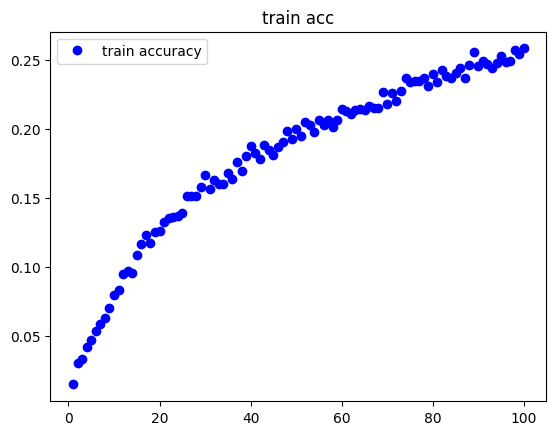

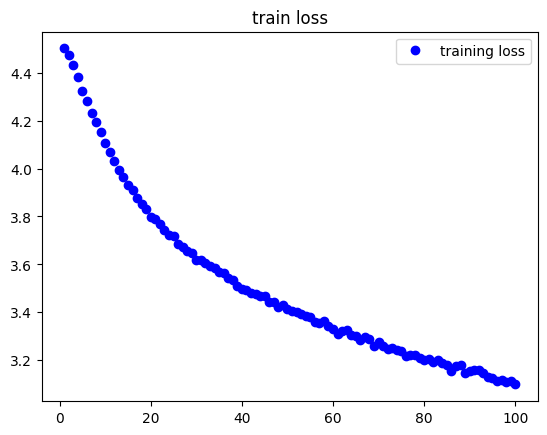

In [10]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)

plt.plot(epochs_range, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes


In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_names = list(test_generator.class_indices.keys())

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
)


conf_matrix = confusion_matrix(y_true, y_pred)

print("Classification Report:")
print(report)

plt.figure(figsize=(10, 10))
sns.heatmap(
    conf_matrix,
    # annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    # xtickrotation=45,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
